# Solution des exercices du chapitre 7

In [1]:
using CSV, DataFrames, Gadfly, LinearAlgebra, Statistics, Distributions

## Exercice 1

In [15]:
# Chargement des données

data = CSV.read("bodyfat.csv", DataFrame)

Y = data[:,:Bodyfat]
n = length(Y)

X = Matrix{Float64}(data[:,[:Triceps, :Thigh, :Midarm]])
p = size(X,2)

3

In [16]:
# Standardisation des données - Pas besoin d'ordonnée à l'origine avec la standardisation

x̄ = mean(X,dims=1)
s = [sqrt(sum((X[i,j]-x̄[j])^2 for i=1:n)) for j in 1:p]

X = (X .- x̄)./s'

Y = Y .- mean(Y);

In [17]:
# Estimation par les moindres carrés

β̂ = (X'X)\X'Y

3-element Vector{Float64}:
  94.89875248629261
 -65.18510696959454
 -34.75299555239801

In [18]:
# Initialisation des variables pour le MCMC

NITER = 1000
β = Array{Float64}(undef, NITER, p)
σ² = Array{Float64}(undef, NITER)

β[1,:] = β̂
σ²[1] = 1

1

In [19]:
#= Échantillonnage de Gibbs. Ici on utilise la paramétrisation canonique de la loi normale multidimensionnelle
pour éviter d'avoir à inverser la matrice de covariance. =#

for i=2:NITER
    
    J = (X'X)/σ²[i-1]
    h = J*β̂
  
    β_ccd = MvNormalCanon(h, J)
    β[i,:] = rand(β_ccd)
    
    a = n/2
    b = (Y - X*β[i,:])'*(Y - X*β[i,:])/2
    
    σ²_ccd = InverseGamma(a, b)
    σ²[i] = rand(σ²_ccd)
    
end

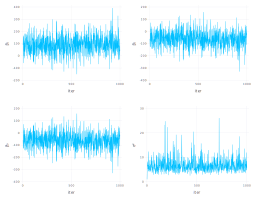

In [20]:
# Convertir le MCMC en DataFrame pour affichage rapide avec Gadfly

# Remarquez la très grande variance des coefficients de régression

MCMC = DataFrame(iter = 1:NITER, β₁ = β[:,1], β₂ = β[:,2], β₃ = β[:,2], σ² = σ²)

fig1 = plot(MCMC, x=:iter, y=:β₁, Geom.line)
fig2 = plot(MCMC, x=:iter, y=:β₂, Geom.line)
fig3 = plot(MCMC, x=:iter, y=:β₃, Geom.line)
fig4 = plot(MCMC, x=:iter, y=:σ², Geom.line)

set_default_plot_size(10inch, 8inch)
gridstack([fig1 fig2; fig3 fig4])

## Exercice 2

In [21]:
# Création d'une fonction permettant de trouver les estimations bayésiennes selon la valeur de λ

β̂_Ridge(λ::Real) = (Diagonal(fill(λ,p)) + X'X)\X'*Y

β̂_Ridge (generic function with 1 method)

In [33]:
# On trouve les estimations ponctuelles bayésiennes des paramètres pour plusieurs valeurs de λ

df = DataFrame(λ = Float64[], Triceps = Float64[], Thigh = Float64[], Midarm = Float64[])
    
for λ = 0:.001:.05
    push!(df,[λ, β̂_Ridge(λ)...])
end

first(df,5)

,λ,Triceps,Thigh,Midarm
,Float64,Float64,Float64,Float64
1,0.0,94.8988,-65.1851,-34.753
2,0.001,45.2892,-20.9398,-15.7733
3,0.002,32.0653,-9.15411,-10.7119
4,0.003,25.9359,-3.69748,-8.36429
5,0.004,22.3981,-0.552798,-7.00807


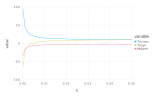

In [34]:
# affichage de l'estimation des paramètres en fonction de λ

# Remarquez combien les estimations changent !

df2 = stack(df, Not(:λ))

set_default_plot_size(6inch, 4inch)
plot(df2,x=:λ, y=:value, color=:variable, Geom.line)


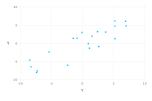

In [35]:
# Il faudrait trouver λ par validation croisée

# supposons que
λ̂ = .005

β̂ = β̂_Ridge(λ̂)

Ŷ = X*β̂

residuals = Y - Ŷ

df4 = DataFrame(Y = Y, Ŷ = Ŷ, Residuals = residuals)

plot(df4,x=:Y, y=:Ŷ, Geom.point)

## Exercice 3


In [36]:
function BIC(X,β̂)
   
    σ̂² = 1/(n-p)*sum( (Y[i] - dot(X[i,:],β̂))^2 for i=1:n)
    
    pd = Normal.(X*β̂,σ̂²)
    
    bic_computation = sum(logpdf.(pd,Y)) - (p+1)/2*log(n)
    
end

BIC (generic function with 1 method)

In [37]:
df = DataFrame(Triceps=Bool[],Thigh=Bool[], Midarm=Bool[], BIC=Float64[])

for x₁ in [false, true]
    for x₂ in [false, true]
        for x₃ in [false, true]
            
            if any([x₁,x₂,x₃])
                X̃ = X[:,[x₁,x₂,x₃]]
                β̂ = (X̃'X̃)\X̃'Y
                
                push!(df,[x₁,x₂,x₃, BIC(X̃,β̂)])
            end
            
        end
    end
end

In [38]:
# Le meilleur modèle sera affiché sur la première ligne

sort(df,:BIC, rev=true)

,Triceps,Thigh,Midarm,BIC
,Bool,Bool,Bool,Float64
1,1,1,1,-60.9562
2,1,0,1,-62.3264
3,1,1,0,-63.0209
4,0,1,1,-63.2169
5,0,1,0,-63.6026
6,1,0,0,-67.9892
7,0,0,1,-91.7006
